# Term_Deposit_Marketing

## Goals

#### Primary Goal:  
####        - Predict if the customer will subscribe (yes/no) to a term deposit (variable y)
#### Secondary Goals: 
####        - Determine the segment(s) of customers our client should prioritize.
####        - What makes the customers buy? Tell us which feature we should be focusing more on.

## Success Criteria

#### - Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

# _________________________________________________________________________

### Data Import

In [9]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import warnings
import logging
import lazypredict
import random
import lightgbm as lgb
import requests
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, make_scorer, recall_score
from sklearn.feature_selection import RFE
from lazypredict.Supervised import LazyClassifier
from hyperopt import fmin, tpe, hp, Trials
warnings.filterwarnings('ignore', category=UserWarning)

In [10]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1EW-XMnGfxn-qzGtGPa3v_C63Yqj2aGf7'
destination = 'term-deposit-marketing-2020.csv'
download_file_from_google_drive(file_id, destination)
df=pd.read_csv(destination)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Data analysis

In [12]:
# check for missing values
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [13]:
# check data types
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

In [14]:
print(df.describe())
print(df.describe(include=['object']))

           age   balance      day  duration  campaign
count 40000.00  40000.00 40000.00  40000.00  40000.00
mean     40.54   1274.28    16.02    254.82      2.88
std       9.64   2903.77     8.28    259.37      3.24
min      19.00  -8019.00     1.00      0.00      1.00
25%      33.00     54.00     8.00    100.00      1.00
50%      39.00    407.00    17.00    175.00      2.00
75%      48.00   1319.00    21.00    313.00      3.00
max      95.00 102127.00    31.00   4918.00     63.00
                job  marital  education default housing   loan   contact  \
count         40000    40000      40000   40000   40000  40000     40000   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
freq           9383    24386      20993   39191   24031  33070     24914   

        month      y  
count   40000  40000  
unique     11      2  
top       may     no  
freq    13532  37104  


In [15]:
for column in df.columns:
    unique_values = df[column].value_counts()
    print(f"Value counts in column '{column}':")
    print(unique_values)
    print("\n")

Value counts in column 'age':
age
32    1909
31    1826
33    1770
34    1730
35    1721
      ... 
90       1
94       1
86       1
95       1
81       1
Name: count, Length: 70, dtype: int64


Value counts in column 'job':
job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64


Value counts in column 'marital':
marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64


Value counts in column 'education':
education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: count, dtype: int64


Value counts in column 'default':
default
no     39191
yes      809
Name: count, dtype: int64


Value counts in column 'balance':
balance
 0         3209
 1          179
 2          141
 4          126
 3 

In [16]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

## Data Visualation

In [18]:
#split data between target 'Y' and variables 'X'
X = df.drop('y',axis=1)
Y = df['y'].to_numpy()

In [19]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1


In [20]:
Y

array(['no', 'no', 'no', ..., 'yes', 'no', 'no'], dtype=object)

In [21]:
X_cont_cols = ['age', 'balance', 'duration', 'campaign']
X_cont = X[X_cont_cols]
X_cont

,age,balance,duration,campaign
0,58,2143,261,1
1,44,29,151,1
2,33,2,76,1
3,47,1506,92,1
4,33,1,198,1
...,...,...,...,...
39995,53,395,107,1
39996,30,3340,238,3
39997,54,200,170,1
39998,34,1047,342,1


In [22]:
X_cat = X.drop(columns=X_cont_cols)
X_cat_cols = X_cat.columns
X_cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day', 'month'],
      dtype='object')

## Subscription status by categorical features

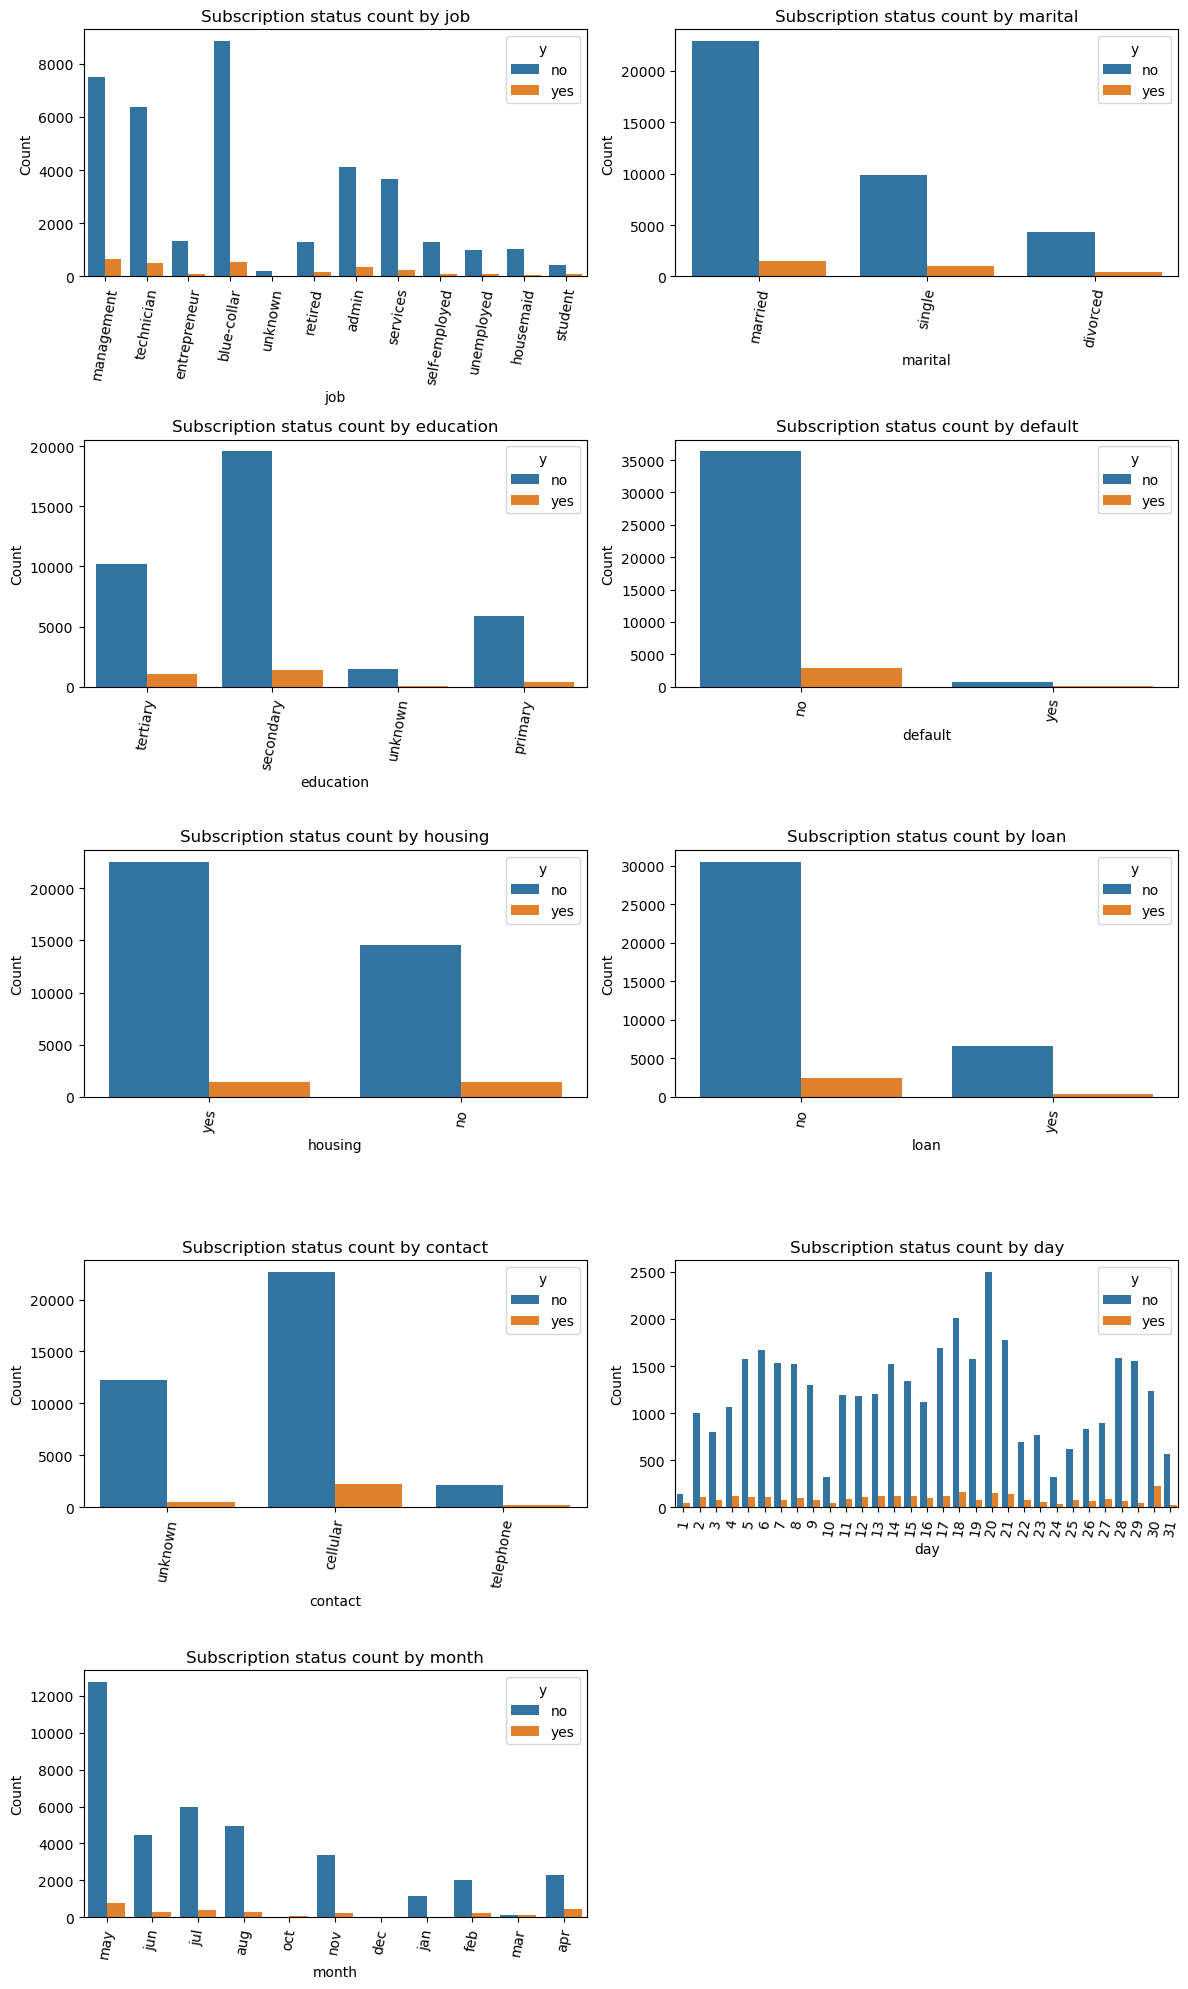

In [24]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(X_cat_cols):
    #success_rate = df.groupby('Orbit')['Class'].mean().reset_index()
    plt.subplot(5, 2, i + 1)
    sns.countplot(data=df, x=col, hue='y')
    plt.title(f'Subscription status count by {col}') 
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

### Percent subscribed by categorical features

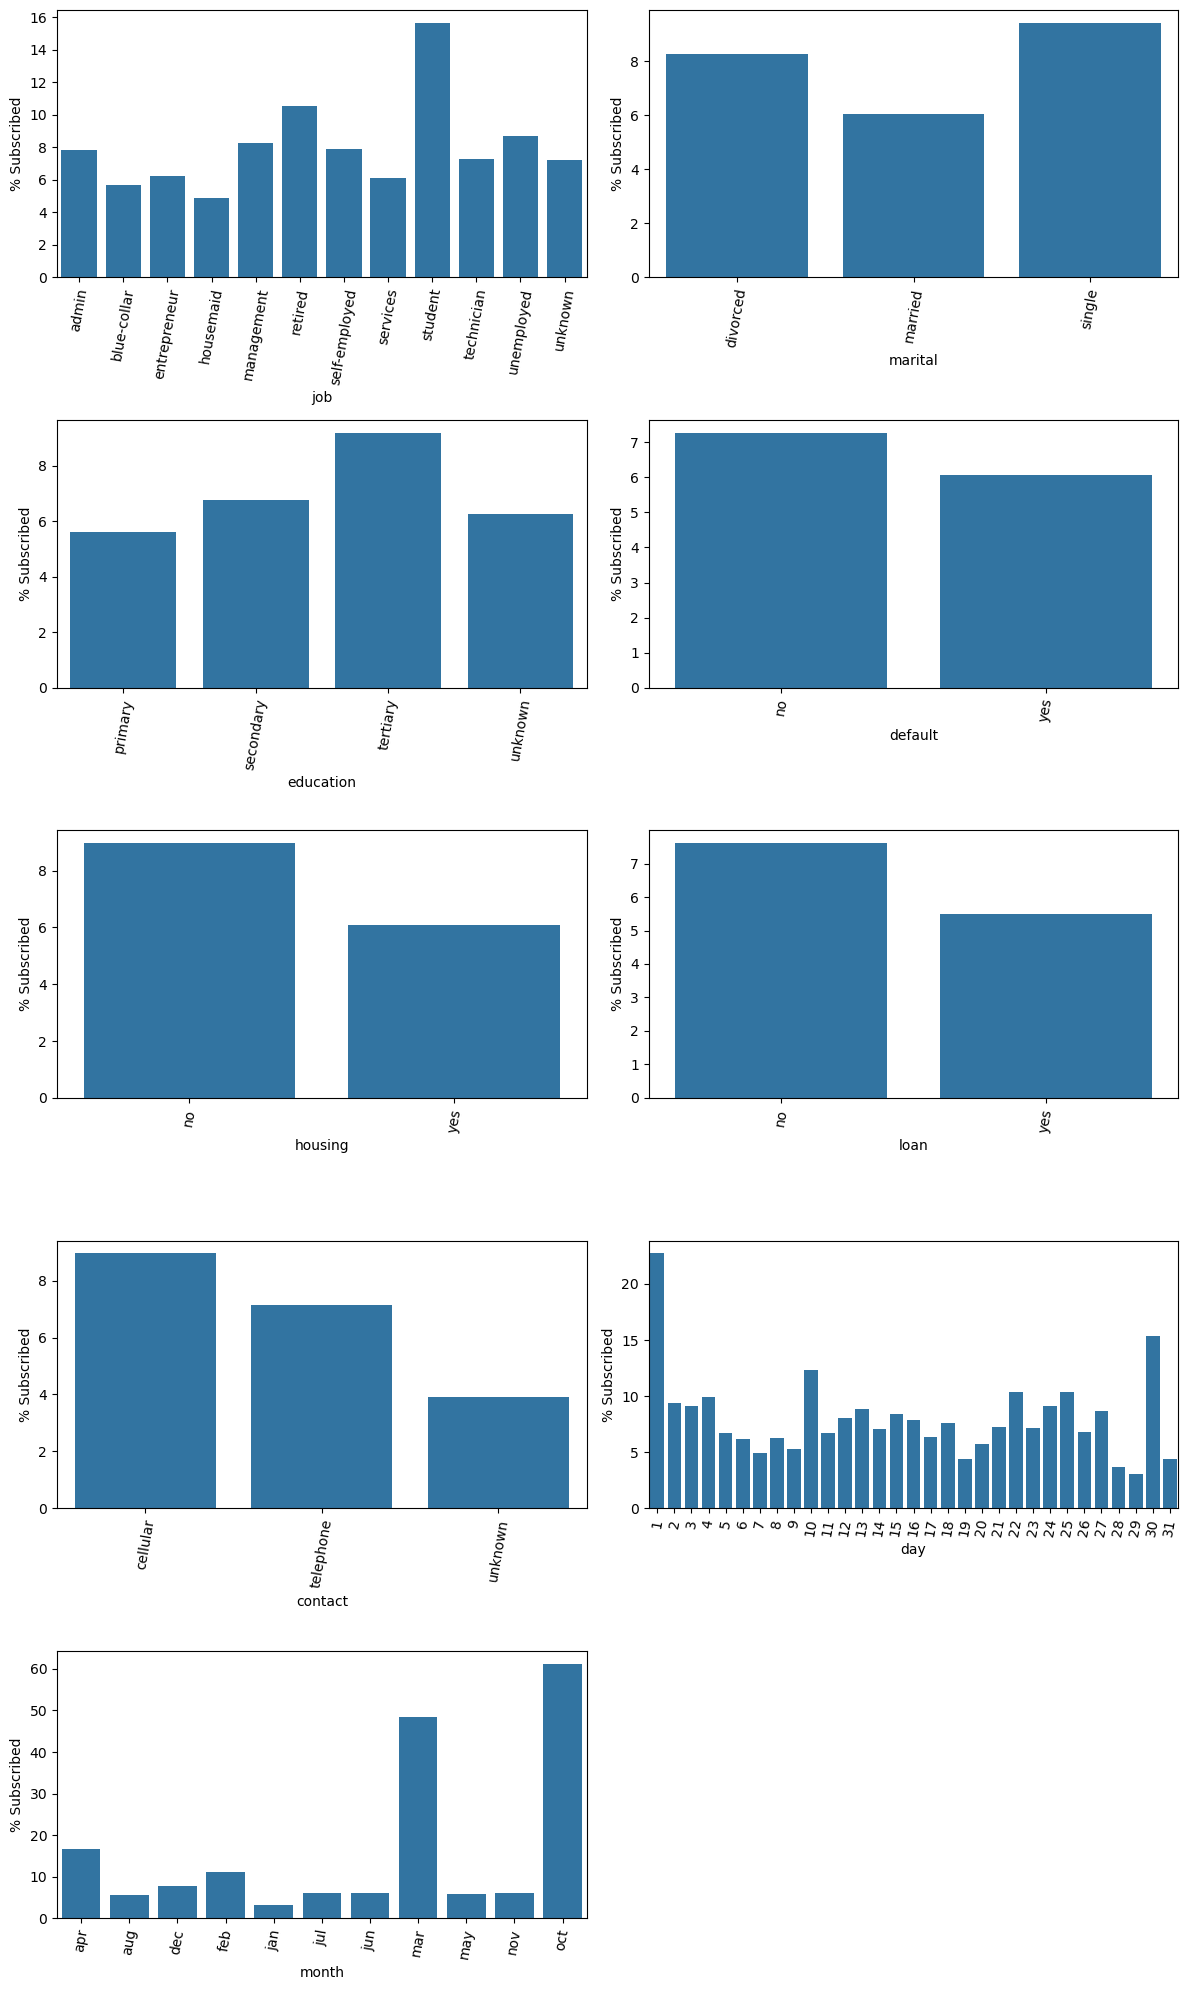

In [26]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(X_cat_cols):
    percentages = (df[df['y'] == 'yes']
               .groupby(col)
               .size()
               / df.groupby(col).size()
               * 100).reset_index(name='Percentage')
    plt.subplot(5, 2, i + 1)
    sns.barplot(x=col, y='Percentage', data=percentages)
    #plt.title(f'{col} vs % subscribed') 
    plt.xlabel(col)
    plt.ylabel('% Subscribed')
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

In [27]:
### Subscription status by continous features

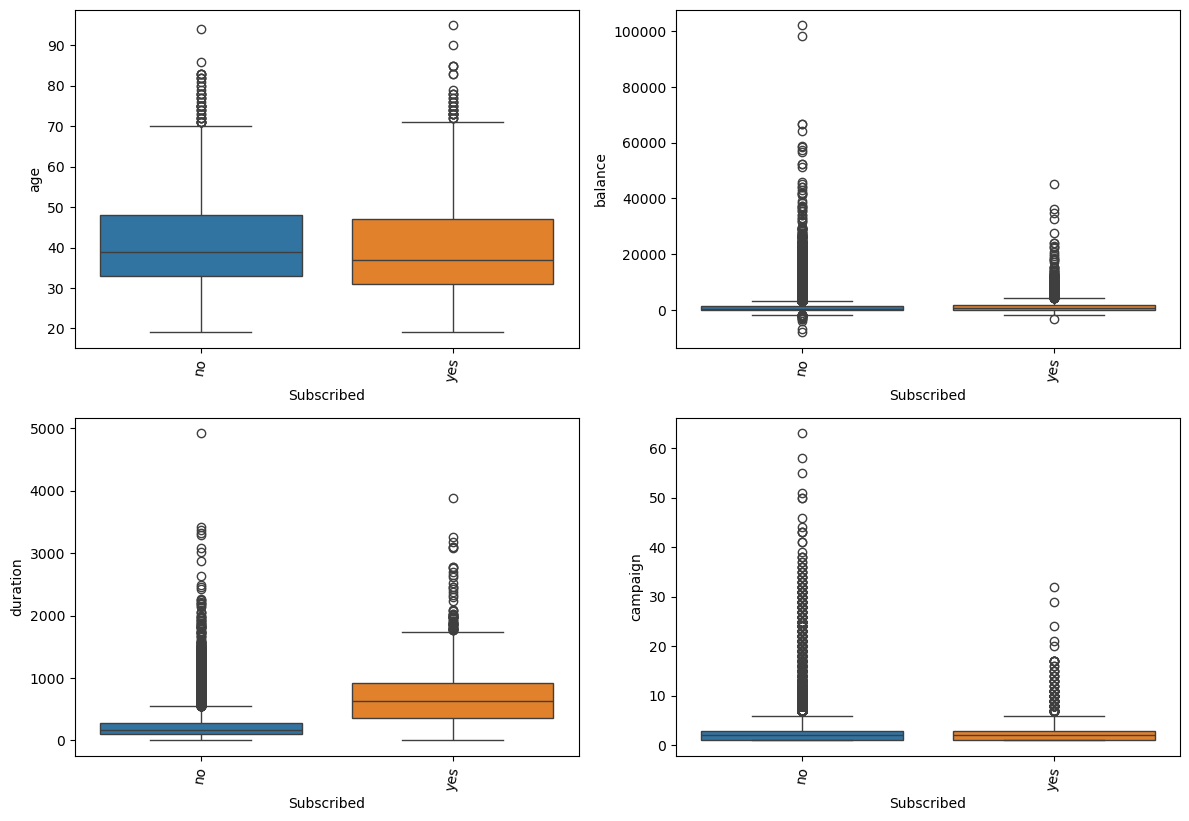

In [28]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(X_cont_cols):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(y=col, x='y', data=df, hue='y')
    plt.xlabel('Subscribed')
    plt.ylabel(col)
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

## Predictive Analysis

### Data preprocessing

In [31]:
df_processed = pd.get_dummies(data=df, columns=['job', 'marital', 'education', 'contact'])
df_processed.head()

,age,default,balance,housing,loan,day,month,duration,campaign,y,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown
0,58,no,2143,yes,no,5,may,261,1,no,...,False,True,False,False,False,True,False,False,False,True
1,44,no,29,yes,no,5,may,151,1,no,...,False,False,True,False,True,False,False,False,False,True
2,33,no,2,yes,yes,5,may,76,1,no,...,False,True,False,False,True,False,False,False,False,True
3,47,no,1506,yes,no,5,may,92,1,no,...,False,True,False,False,False,False,True,False,False,True
4,33,no,1,no,no,5,may,198,1,no,...,False,False,True,False,False,False,True,False,False,True


In [32]:
df_processed.replace(['no', 'yes'], [0,1], inplace=True)
df_processed.head()

,age,default,balance,housing,loan,day,month,duration,campaign,y,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown
0,58,0,2143,1,0,5,may,261,1,0,...,False,True,False,False,False,True,False,False,False,True
1,44,0,29,1,0,5,may,151,1,0,...,False,False,True,False,True,False,False,False,False,True
2,33,0,2,1,1,5,may,76,1,0,...,False,True,False,False,True,False,False,False,False,True
3,47,0,1506,1,0,5,may,92,1,0,...,False,True,False,False,False,False,True,False,False,True
4,33,0,1,0,0,5,may,198,1,0,...,False,False,True,False,False,False,True,False,False,True


In [33]:
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

# Apply the mapping to the 'month' column
df_processed['month_number'] = df_processed['month'].map(month_map)
df_processed = df_processed.drop(columns=['month'])
df_processed.head()

,age,default,balance,housing,loan,day,duration,campaign,y,job_admin,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_number
0,58,0,2143,1,0,5,261,1,0,False,...,True,False,False,False,True,False,False,False,True,5
1,44,0,29,1,0,5,151,1,0,False,...,False,True,False,True,False,False,False,False,True,5
2,33,0,2,1,1,5,76,1,0,False,...,True,False,False,True,False,False,False,False,True,5
3,47,0,1506,1,0,5,92,1,0,False,...,True,False,False,False,False,True,False,False,True,5
4,33,0,1,0,0,5,198,1,0,False,...,False,True,False,False,False,True,False,False,True,5


In [34]:
df_processed = df_processed.astype(float)
df_processed.head()

,age,default,balance,housing,loan,day,duration,campaign,y,job_admin,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_number
0,58.00,0.00,2143.00,1.00,0.00,5.00,261.00,1.00,0.00,0.00,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,5.00
1,44.00,0.00,29.00,1.00,0.00,5.00,151.00,1.00,0.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,5.00
2,33.00,0.00,2.00,1.00,1.00,5.00,76.00,1.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,5.00
3,47.00,0.00,1506.00,1.00,0.00,5.00,92.00,1.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,5.00
4,33.00,0.00,1.00,0.00,0.00,5.00,198.00,1.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,5.00


In [35]:
X_processed = df_processed.drop('y',axis=1)
Y_processed = df_processed['y'].to_numpy()
X_processed.head()

,age,default,balance,housing,loan,day,duration,campaign,job_admin,job_blue-collar,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_number
0,58.00,0.00,2143.00,1.00,0.00,5.00,261.00,1.00,0.00,0.00,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,5.00
1,44.00,0.00,29.00,1.00,0.00,5.00,151.00,1.00,0.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,5.00
2,33.00,0.00,2.00,1.00,1.00,5.00,76.00,1.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,5.00
3,47.00,0.00,1506.00,1.00,0.00,5.00,92.00,1.00,0.00,1.00,...,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,5.00
4,33.00,0.00,1.00,0.00,0.00,5.00,198.00,1.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,5.00


In [36]:
Y_processed

array([0., 0., 0., ..., 1., 0., 0.])

In [37]:
transform = preprocessing.StandardScaler()
X_processed = pd.DataFrame(transform.fit_transform(X_processed),columns=X_processed.columns)
X_processed.head()

,age,default,balance,housing,loan,day,duration,campaign,job_admin,job_blue-collar,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_number
0,1.81,-0.14,0.30,0.82,-0.46,-1.33,0.02,-0.58,-0.36,-0.55,...,0.80,-0.61,-0.43,-1.05,1.60,-0.20,-1.29,-0.25,1.46,-0.44
1,0.36,-0.14,-0.43,0.82,-0.46,-1.33,-0.40,-0.58,-0.36,-0.55,...,-1.25,1.64,-0.43,0.95,-0.62,-0.20,-1.29,-0.25,1.46,-0.44
2,-0.78,-0.14,-0.44,0.82,2.18,-1.33,-0.69,-0.58,-0.36,-0.55,...,0.80,-0.61,-0.43,0.95,-0.62,-0.20,-1.29,-0.25,1.46,-0.44
3,0.67,-0.14,0.08,0.82,-0.46,-1.33,-0.63,-0.58,-0.36,1.81,...,0.80,-0.61,-0.43,-1.05,-0.62,5.01,-1.29,-0.25,1.46,-0.44
4,-0.78,-0.14,-0.44,-1.23,-0.46,-1.33,-0.22,-0.58,-0.36,-0.55,...,-1.25,1.64,-0.43,-1.05,-0.62,5.01,-1.29,-0.25,1.46,-0.44


In [38]:
seed = random.randint(1000,9999)
### good seeds 
#seed = 4547
print(seed)



5801


In [39]:
# Split data in test and training sets
X_train, X_test, y_train, y_test = train_test_split(X_processed,Y_processed, test_size=0.2, random_state=seed)

In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(32000, 31)
(32000,)
(8000, 31)
(8000,)


In [41]:
# code to suppress lightGBM when running Lazy Classifer
class CustomLogger:
    def __init__(self): 
        self.logger = logging.getLogger('lightgbm_custom') 
        self.logger.setLevel(logging.ERROR)
        
    def info(self, message): 
        self.logger.info(message) 
        
    def warning(self, message): 
        pass# Suppress warnings by not doing anything pass 
        
    def error(self, message): 
        self.logger.error(message) 
# Register the custom logger 
lgb.register_logger(CustomLogger())

In [42]:
#use lazy predict show results from various classifier models
clf = LazyClassifier(random_state = seed)
models = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:44<00:00,  3.62s/it]

(                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.87               0.81     0.81      0.89   
QuadraticDiscriminantAnalysis      0.85               0.70     0.70      0.87   
LGBMClassifier                     0.93               0.69     0.69      0.93   
GaussianNB                         0.90               0.69     0.69      0.90   
XGBClassifier                      0.93               0.68     0.68      0.93   
DecisionTreeClassifier             0.91               0.68     0.68      0.91   
LinearDiscriminantAnalysis         0.92               0.66     0.66      0.92   
BaggingClassifier                  0.93               0.65     0.65      0.92   
Perceptron                         0.92               0.65     0.65      0.92   
LabelPropagation                   0.92               0.65     0.65      0.91   
LabelSpreading             

In [43]:
rf_best.fit(X_train, y_train)


recall_scores = []
for n_features in range(1, X_train.shape[1] + 1):
    # Initialize RFE
    rfe = RFE(estimator=rf_best, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    
    # Perform cross-validation
    y_pred = rfe.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'], output_dict=True) 
    recall = report['Unhappy']['recall']
    recall_scores.append((n_features,recall))
    
    
    #plot_confusion_matrix(y_test,y_pred)

# Find the number of features with the best score
best_n_features = max(recall_scores, key=lambda x: x[1])[0]
best_recall_score = max(recall_scores, key=lambda x: x[1])[1]
print(f'Optimal Number of Features: {best_n_features}')
print(f'Best recall score for Unhappy: {best_recall_score}')

# Use selected features to train the final model
rfe = RFE(estimator=rf_best, n_features_to_select=best_n_features)
fit = rfe.fit(X_train, y_train)
selected_features = X_train.columns[fit.support_]
print(f'Selected features: {selected_features}')

NameError: name 'rf_best' is not defined

In [ ]:
# retrain rf model on selected features and hyper 

X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Define the objective function
def objective_rf(params):
    rf = RandomForestClassifier(**params, random_state=seed)
    rf.fit(X_train_selected, y_train)
    pred_rf = rf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, pred_rf)
    return -accuracy

# Define the hyperparameter search space
search_rf = {
    'n_estimators': hp.choice('n_estimators', range(10, 200)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

# Minimize the objective function
trials_rf = Trials()
best_rf = fmin(fn=objective_rf,
            space=search_rf,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials_rf,
            rstate=np.random.default_rng(seed))

print("Best parameters found: ", best_rf) 